In [2]:
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
from evaluation_functions import ensemble_evaluation_functions as eef

import matplotlib as mpl
import os

import huxt as H
import huxt_analysis as HA
import huxt_inputs as Hin

import scipy.interpolate
from scipy import integrate


### Reading and Preparing Ensemble Sets and Omni Data

In [51]:
### Reading in multiple Carrington rotations worth of ensemble sets and OMNI data

### Read in OMNI data for evaluating ensemble forecasts against

# omni data directory
omni_data_dir = 'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\OMNI\\Processed_omni\\'

# load the data into dataframe and index by datetime
omni_data = pd.read_hdf(omni_data_dir + 'omni_1hour.h5')
omni_data = omni_data.set_index('datetime')

### Read in ensemble sets for desired carrington rotations
cr_min = 2078
cr_max = 2226

cr_list = np.arange(cr_min,cr_max)
#elements_to_remove = np.arange(2098,2108)
#cr_list = np.setdiff1d(cr_list, elements_to_remove)
print(cr_list)
lat_var = 15
ensemble_size = 100
file_details_list = [(cr, ensemble_size, lat_var) for cr in cr_list]

ensemble_sets = []
data_sets = []

for params in file_details_list:

    # Open forecast output and resample onto OMNI timestep
    ensemble_members, data_chunk = eef.read_and_prepare_ensemble_data(file_details=params, observed_data=omni_data) 
    ensemble_sets.append(ensemble_members)
    data_sets.append(data_chunk)


### Combining the ensemble and data chunks into a single timeseries for evaluation
combined_ensemble_members = []

# Create a new list of lists
for i in range(ensemble_size):
    list_of_cr_members = [[sublist[i] for sublist in ensemble_sets]]
    combined_ensemble_members.append(np.concatenate(list_of_cr_members[0]))

combined_data = pd.concat(data_sets)

[2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091
 2092 2093 2094 2095 2096 2097 2098 2099 2100 2101 2102 2103 2104 2105
 2106 2107 2108 2109 2110 2111 2112 2113 2114 2115 2116 2117 2118 2119
 2120 2121 2122 2123 2124 2125 2126 2127 2128 2129 2130 2131 2132 2133
 2134 2135 2136 2137 2138 2139 2140 2141 2142 2143 2144 2145 2146 2147
 2148 2149 2150 2151 2152 2153 2154 2155 2156 2157 2158 2159 2160 2161
 2162 2163 2164 2165 2166 2167 2168 2169 2170 2171 2172 2173 2174 2175
 2176 2177 2178 2179 2180 2181 2182 2183 2184 2185 2186 2187 2188 2189
 2190 2191 2192 2193 2194 2195 2196 2197 2198 2199 2200 2201 2202 2203
 2204 2205 2206 2207 2208 2209 2210 2211 2212 2213 2214 2215 2216 2217
 2218 2219 2220 2221 2222 2223 2224 2225]


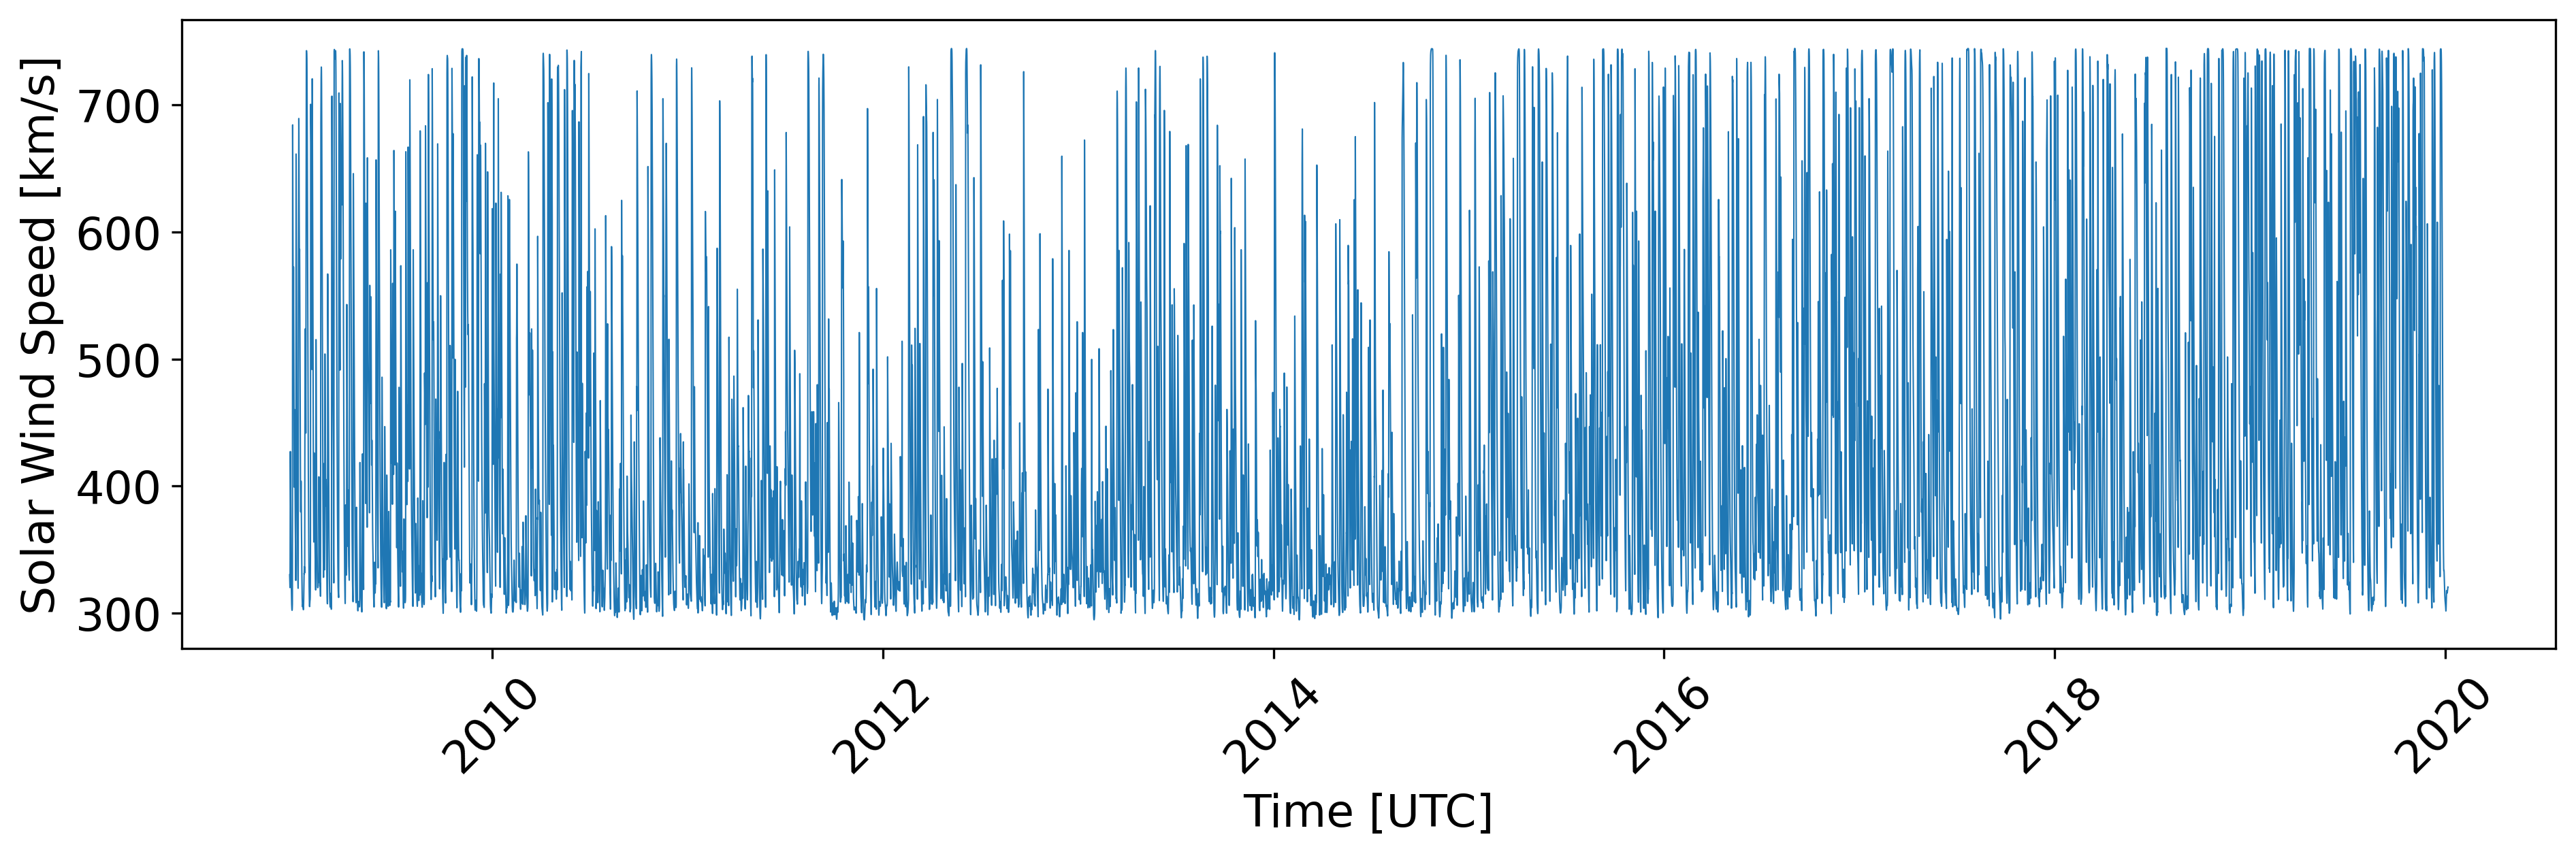

In [52]:
plt.figure(figsize = (15,4), dpi = 300)

# for vsw in  combined_ensemble_members:
#     plt.plot(combined_data.index, vsw, color = 'grey', alpha = 0.2)

plt.plot(combined_data.index, combined_ensemble_members[3], lw = 0.5)
plt.xlabel('Time [UTC]')
plt.ylabel('Solar Wind Speed [km/s]')
#plt.xlim(combined_data.index[100],combined_data.index[700])
plt.xticks(rotation = 45)
plt.show()

### Generating Deterministic Forecast

In [6]:
def generate_deterministic_forecast(cr, forecast_window, dt_scale, r_min):

    # Use the HUXt ephemeris data to get Earth lat over the CR
    dummymodel = H.HUXt(v_boundary=np.ones(128)*400*(u.km/u.s), simtime=forecast_window, dt_scale=dt_scale, cr_num=cr, lon_out=0.0*u.deg)

    # Retrieve a bodies position at each model timestep:
    earth = dummymodel.get_observer('earth')

    # Get average Earth lat
    E_lat = np.nanmean(earth.lat_c)

    # Get MAS profile for specific carrington rotation and Earth latitude calculated previously
    v_mas = Hin.get_MAS_long_profile(cr, E_lat.to(u.deg))

    model = H.HUXt(v_boundary=v_mas, cr_num=cr, simtime=forecast_window, dt_scale=dt_scale, r_min=r_min)
    model.solve([])

    # Extract Earth time series dataFrame
    df_earth_series = HA.get_observer_timeseries(model, observer = 'Earth')
    df_earth_series = df_earth_series.rename(columns = {'time':'datetime'})
    df_earth_series.set_index('datetime')
    
    return df_earth_series

def read_deterministic_forecast_cdf(cr):
    
    input_file = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_forecasting\\data\\deterministic_forecasts\\deterministic_CR{cr}.nc'

    # Read the NetCDF file into an xarray Dataset
    loaded_ds = xr.open_dataset(input_file)

    df = loaded_ds.sel().to_dataframe()

    return df

In [8]:
### Generate HUXt deterministic forecast

# Read in deterministic HUXt output
deterministic_HUXt_ouput_list = [read_deterministic_forecast_cdf(cr) for cr in cr_list]

In [9]:
# Resample deterministic forecast onto omni data timestep
resampled_deterministic_output = []
for i, df in enumerate(deterministic_HUXt_ouput_list):

    df_ = df.set_index('datetime')
    resampled_forecast = eef.interpolate_and_resample(observed_data_index = data_sets[i].index, forecast_index=df_.index, forecast=df_['vsw'])
    resampled_deterministic_output.append(resampled_forecast)

# Create single timeseries dataframe with datetime index from omni 
deterministic_forecast = np.concatenate(resampled_deterministic_output)
deterministic_forecast = pd.DataFrame({'vsw': deterministic_forecast}, index = combined_data.index)

### Generating Recurrence Forecast

In [10]:
## Define carrington rotation offset for index
carrington_rotation = pd.Timedelta(27.25, unit = 'days')
omni_data_reccurance = omni_data.dropna(subset = ['V']) # Remove rows with NaN values

# Isolate data within forecast range + backward additional month needed for 1st carrington rotations of forecast
omni_data_reccurance = omni_data_reccurance.loc[(combined_data.index[0]-carrington_rotation):combined_data.index[-1]]

# Grab index from isolated reccurence data set
omni_data_index = omni_data_reccurance.index

# Project index forward by 1 carrington rotation
reccurance_forecast_index = omni_data_index + carrington_rotation

# Set index for reccurent forecast to the new forward projected datetime series
reccurance_forecast = omni_data_reccurance.set_index(reccurance_forecast_index)
reccurance_forecast = reccurance_forecast.loc[pd.to_datetime(reccurance_forecast.index[0]):pd.to_datetime(omni_data.index[-1])]

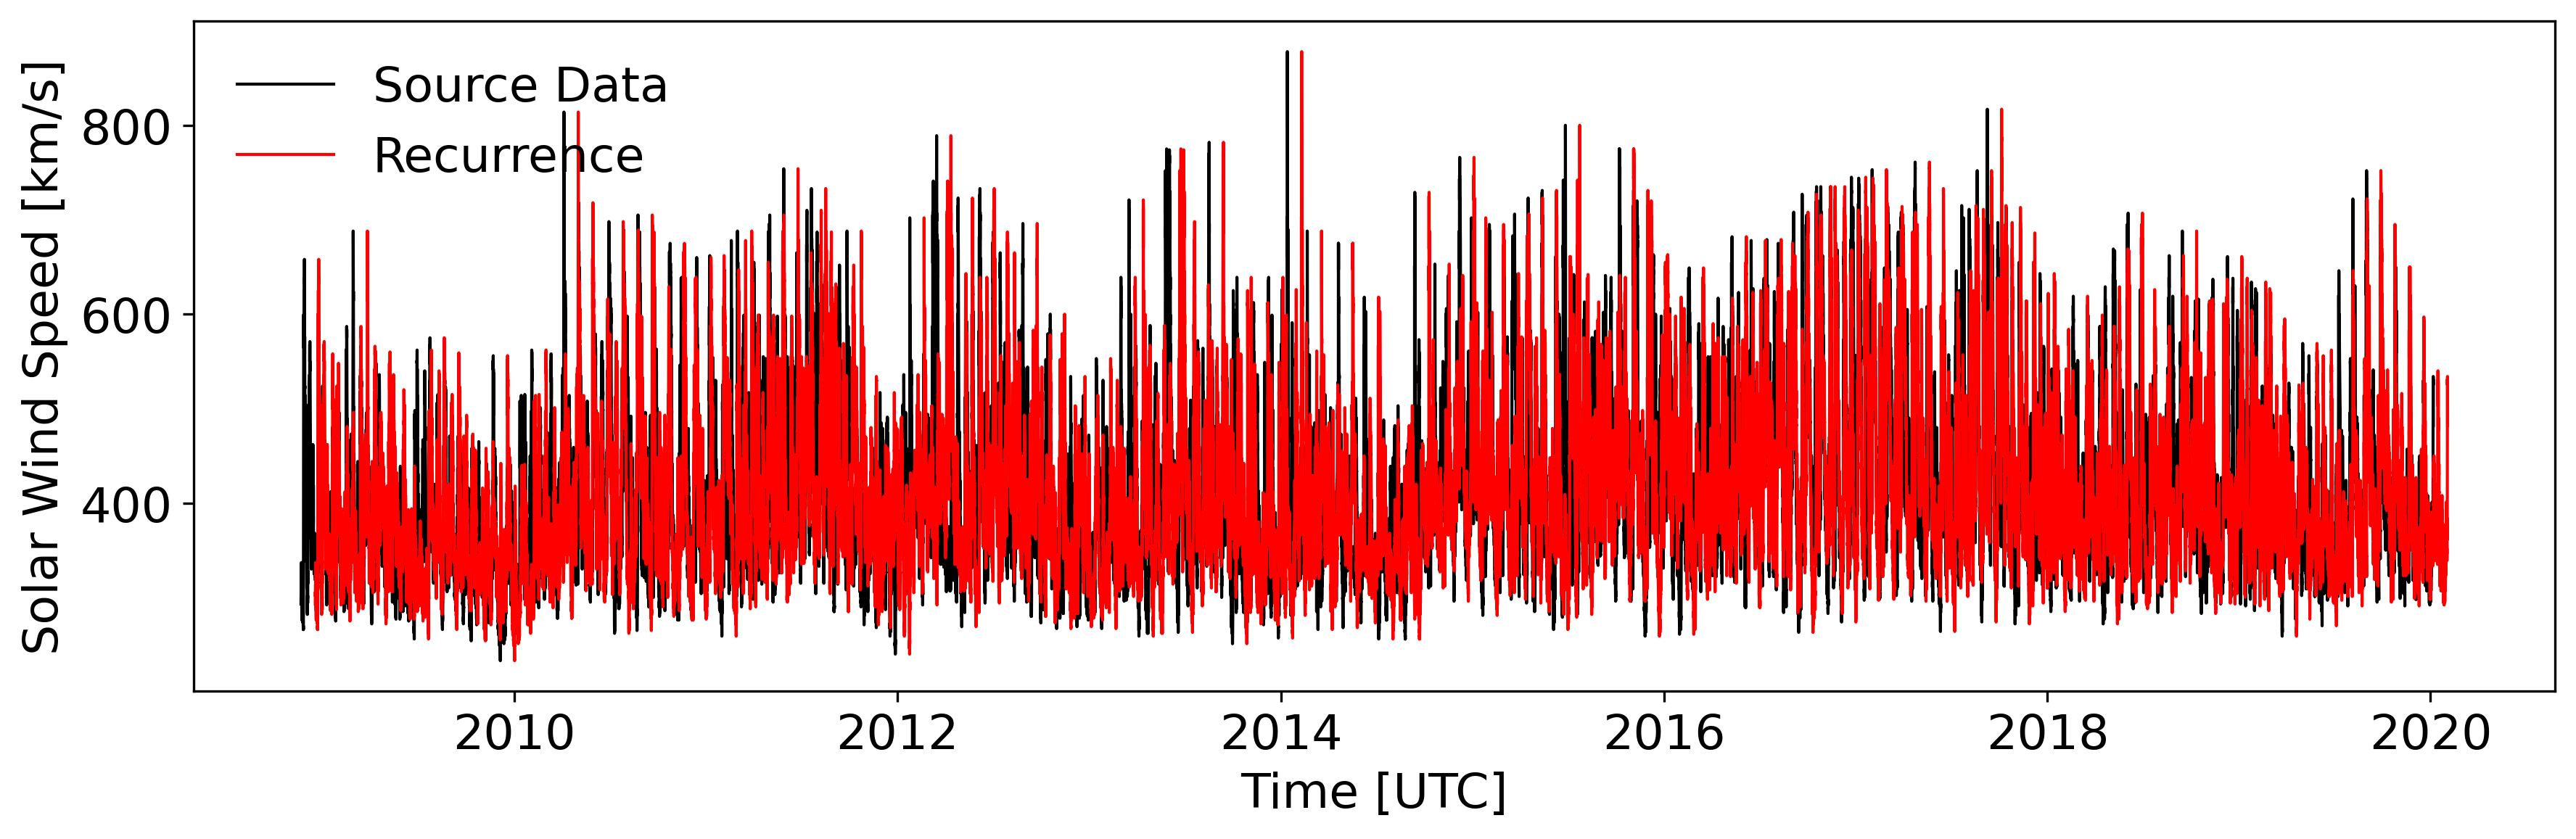

In [12]:
plt.figure(dpi = 300, figsize = (14,4))
plt.plot(omni_data_reccurance['V'], label = 'Source Data', color = 'black', lw = 1)
plt.plot(reccurance_forecast['V'], label = 'Recurrence', color = 'red', lw = 1)
plt.ylabel('Solar Wind Speed [km/s]')
plt.xlabel('Time [UTC]')
plt.legend(frameon = False)
plt.show()

### Compute Briers Score and ROC curve

In [57]:
### Compute ROC curves for each forecast
roc_curve_rec = eef.generate_roc_curve(forecast=reccurance_forecast['V'], observed_data=omni_data['V'], threshold_range=(100,800), threshold_num=30)
roc_curve_ensemble = eef.generate_roc_curve_from_ensemble(ensemble_members=combined_ensemble_members, observed_data=combined_data['V'],probability_threshold=0.1, threshold_range=(100,800), threshold_num=30)
roc_curve_deterministic = eef.generate_roc_curve(forecast=deterministic_forecast, observed_data=omni_data['V'], threshold_range=(100,800), threshold_num=30)

### Compute briers scores
BS_thresh = 600 # km/s

rec_BS = eef.compute_brier_score(forecast=reccurance_forecast['V'], observed_data=combined_data['V'], threshold=BS_thresh)
ensemble_BS = eef.compute_brier_score_probabilistic(ensemble_members=combined_ensemble_members, observed_data=combined_data['V'], threshold=BS_thresh, ensemble_size=len(combined_ensemble_members))
deterministic_BS = eef.compute_brier_score(forecast=deterministic_forecast['vsw'], observed_data=combined_data['V'], threshold=BS_thresh)

print(f'Briers Scores: Ensemble - {ensemble_BS:.2f}, Deterministic - {deterministic_BS:.2f}, Recurrence - {rec_BS:.2f}')

Briers Scores: Ensemble - 0.09, Deterministic - 0.13, Recurrence - 0.07


In [15]:
def compute_roc_score(roc_curve):
    """
    Computes integrates area under ROC curve using scipy quad returning integrated area as the ROC score

    Parameters:
    - roc_curve (list): list of tuples which each contain the hit rate and false alarm rate calculated at different thresholds

    Returns:
    - result (float): ROC Score calculated as the integrated area under ROC curve
    """

    # Unpack and prepare roc curve data
    y,x = zip(*roc_curve)

    x = np.array([xx for xx in x])
    y = np.array([yy for yy in y])

    nan_mask_x = ~np.isnan(x)
    nan_mask_y = ~np.isnan(y)

    nan_mask = np.logical_and(nan_mask_x, nan_mask_y)

    x = x[nan_mask]
    y = y[nan_mask]

    # Interpolate the curve
    interp_function = scipy.interpolate.interp1d(x, y, kind='linear')

    # Define the integration limits
    a = min(x)
    b = max(x)

    # Perform the integration
    result, error = integrate.quad(interp_function, a, b)

    return result


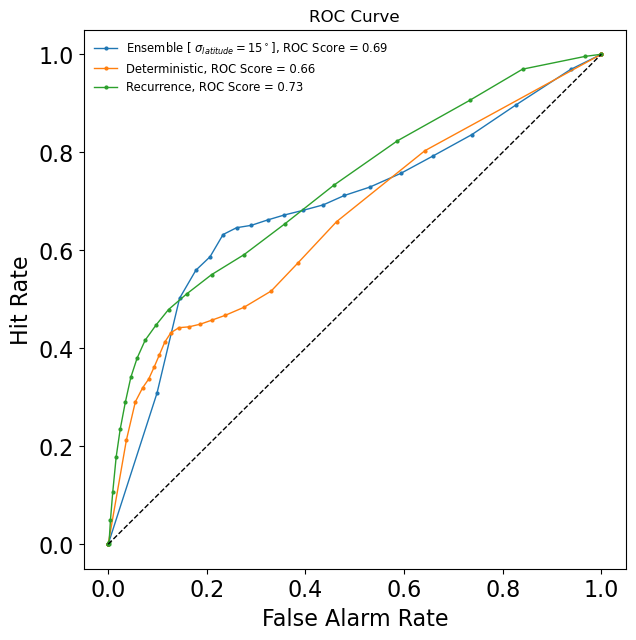

In [58]:
roc_curve_list = [roc_curve_ensemble, roc_curve_deterministic, roc_curve_rec]
roc_labels = [f'Ensemble [ $\sigma_{{latitude}}={lat_var}^\circ$], ROC Score = {compute_roc_score(roc_curve_ensemble):.2f}', 
              f'Deterministic, ROC Score = {compute_roc_score(roc_curve_deterministic):.2f}', 
              f'Recurrence, ROC Score = {compute_roc_score(roc_curve_rec):.2f}']

plt.figure(dpi=100, figsize=(7,7)) 

for i, roc in enumerate(roc_curve_list):    

    hit_rate, false_alarm_rate = zip(*roc)    
    plt.plot(false_alarm_rate, hit_rate, marker = 'o', markersize = 2, linewidth = 1, label = roc_labels[i])

plt.plot([0,1], [0,1], linestyle = '--', lw = 1, color = 'black')
plt.title('ROC Curve')
plt.xlabel('False Alarm Rate')
plt.ylabel('Hit Rate')
plt.legend(frameon = False, fontsize = 'small')

plt.show()

### ROC Curve Probability Event Threshold

In [55]:
prob_thresh_list = np.linspace(0.1,0.9,20)

ensemble_score_across_threshold = []
ensemble_ROC_curves = []

for thresh in prob_thresh_list: 
    new_roc_curve = eef.generate_roc_curve_from_ensemble(ensemble_members=combined_ensemble_members, observed_data=combined_data['V'],
                                                         probability_threshold=thresh, threshold_range=(100,800), threshold_num=30)
    ensemble_score_across_threshold.append(compute_roc_score(new_roc_curve))
    ensemble_ROC_curves.append(new_roc_curve)
    

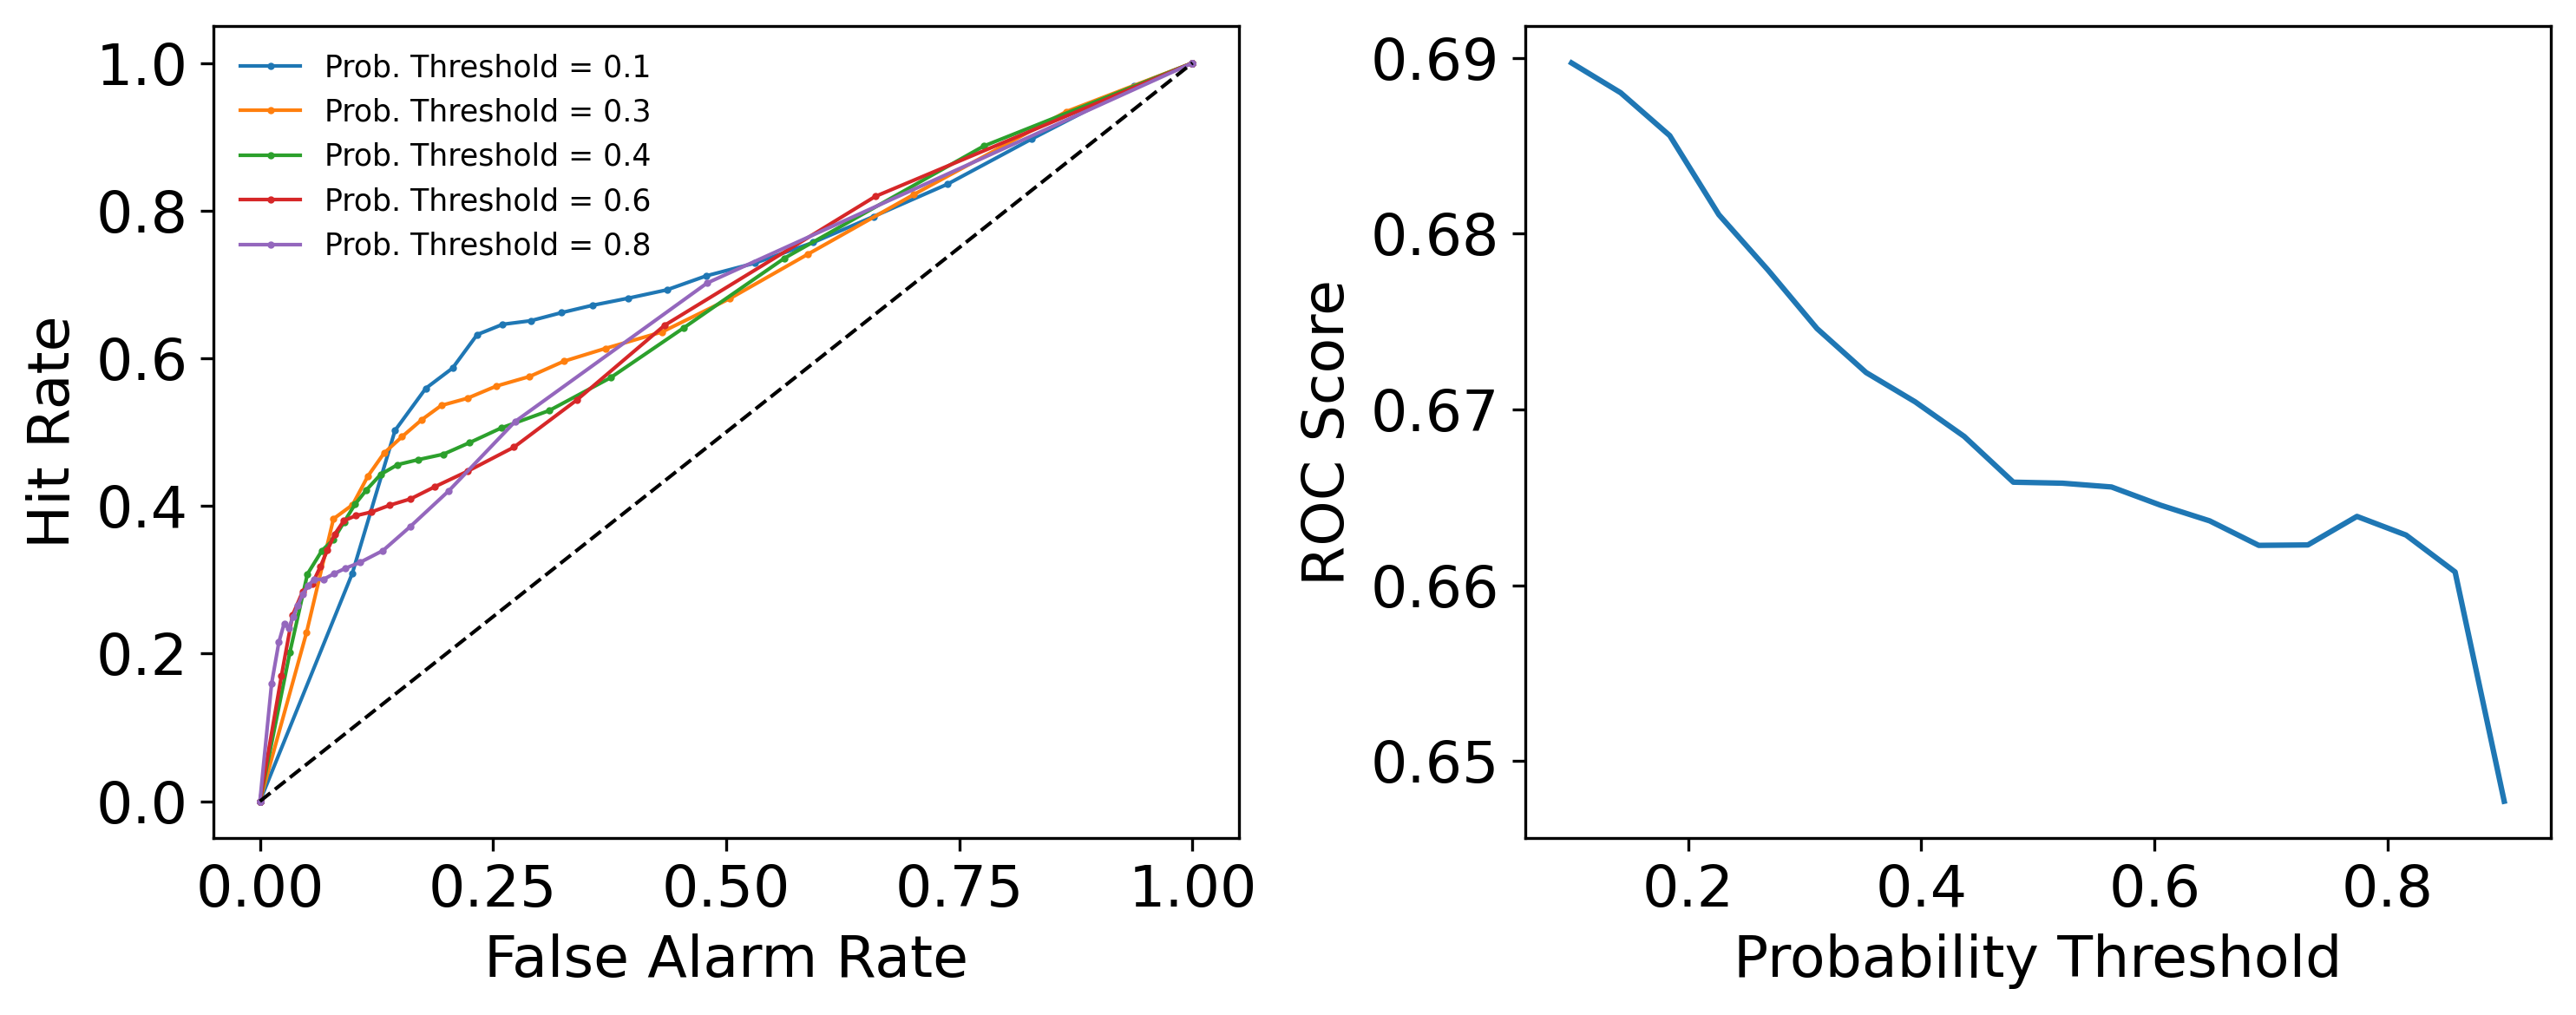

In [56]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, dpi = 300, figsize = (10,4))

for ii, ROC_curve in enumerate(ensemble_ROC_curves):
    if ii % 4 == 0:
        hit_rate, false_alarm_rate = zip(*ROC_curve)    
        axes[0].plot(false_alarm_rate, hit_rate, marker = 'o', markersize = 1, linewidth = 1, label = f'Prob. Threshold = {prob_thresh_list[ii]:.1f}')
    else:
        pass

axes[0].plot([0,1], [0,1], linestyle = '--', lw = 1, color = 'black')
axes[0].set_xlabel('False Alarm Rate')
axes[0].set_ylabel('Hit Rate')
axes[0].legend(frameon = False, fontsize = 'small')

axes[1].plot(prob_thresh_list, ensemble_score_across_threshold)
axes[1].set_xlabel('Probability Threshold')
axes[1].set_ylabel('ROC Score')

plt.tight_layout()
plt.show()
    



### Expanding evaluation for testing across the ensemble perturbation scheme
# Brier Score

In [60]:
def read_and_combine_ensemble_sets_and_data(cr_range, lat_var, ensemble_size, observed_data):    

    ### Read in ensemble sets for desired carrington rotations
    cr_min = cr_range[0]
    cr_max = cr_range[1]

    cr_list = np.arange(cr_min,cr_max)

    # prepare file details
    file_details_list = [(cr, ensemble_size, lat_var) for cr in cr_list]

    # initialise lists for storing ensemble and data portions
    ensemble_sets = []
    data_sets = []

    for params in file_details_list:

        # Open forecast output and resample onto OMNI timestep
        ensemble_members, data_chunk = eef.read_and_prepare_ensemble_data(file_details=params, observed_data=observed_data) 
        ensemble_sets.append(ensemble_members)
        data_sets.append(data_chunk)

    ### Combining the ensemble and data chunks into a single timeseries for evaluation
    combined_ensemble_members = []

    # Create a new list of lists
    for i in range(ensemble_size):
        list_of_cr_members = [[sublist[i] for sublist in ensemble_sets]]
        combined_ensemble_members.append(np.concatenate(list_of_cr_members[0]))

    # Create single dataframe of data used to resample ensemble output for easy direct comparison
    combined_data = pd.concat(data_sets)

    return combined_ensemble_members, combined_data, data_sets

def perturb_longitude(shift_amount, ensemble_member):
    
    # Ensure that the DataFrame has a datetime index
    if not isinstance(ensemble_member.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a datetime index")
    
    shift_amount = int(long_pert_dt.to(u.second).value) # Convert shift amount into seconds

    # Convert datetime index into integers
    numeric_index = ensemble_member.index.astype(int) // 10**9 # Floor division to convert into seconds (UNIX int datetime is in nanoseconds)
    numeric_index = numeric_index.to_numpy()

    # Calculate the new index by shifting with wrapping
    shifted_index = numeric_index + shift_amount

    # Generate boolean array which captures elements above and below max/min indices
    wrap_mask = (shifted_index < numeric_index.min()) | (shifted_index > numeric_index.max())
  
    if shift_amount < 0:
        # If negative shift amount (i.e. elements will be below min index)
        shifted_index[wrap_mask] = shifted_index[wrap_mask] + (shifted_index.max() - shifted_index.min())

    elif shift_amount > 0:
        # If positive shift amount (i.e. elements will be above max index)  
        shifted_index[wrap_mask] = shifted_index[wrap_mask] - (shifted_index.max() - shifted_index.min())

    else:
        # No change -- preserve original index
        shifted_index = numeric_index

    # Convert back to datetime index
    new_converted_index = pd.to_datetime(shifted_index, unit='s')

    # Sort the DataFrame based on the new index
    df_shifted = ensemble_member.copy()
    df_shifted = (df_shifted.sort_index().set_index(new_converted_index)).sort_index()
    
    return df_shifted[~(df_shifted.index).duplicated()].copy()

In [61]:
def gen_probabilistic_forecast(ensemble_members, threshold, ensemble_size): 
    """
    Converts a set of ensemble members into a probabilistic forecast based on a threshold.

    Parameters:
    - ensemble_members (list): List containing separate ensemble member timeseries within each element
    - threshold (float): Wind speed threshold value of forecast (above which forecast is catagorised as a 'hit')
    - ensemble_size (int): Number of individual ensemble members
    
    Returns:
    - probabilistic_forecast (numpy array): probabilistic forecast (between 0 and 1).
    """

    # Compare individual ensemble member forecast timeseries to chosen threshold
    ranked_forecasts = np.array([forecast > threshold for forecast in ensemble_members])

    # Sum along zeroth axis to produce array where each element counts the number of ensemble members above threshold for given timestep
    summed_ranks = np.sum(ranked_forecasts, axis = 0) 

    return summed_ranks/ensemble_size

def compute_brier_score_probabilistic_padded(ensemble_members, observed_data, threshold, ensemble_size):
    """
    Calculates the Brier Score for a probabilistic forecast generated by an ensemble with ability to pad datasets to length

    Parameters:
    - ensemble_members (list): List containing separate ensemble member timeseries within each element
    - observed_data (numpy array): Array containing observed timeseries values
    - threshold (float): Wind speed threshold value for evaluating forecast (above which a forecast value is catagorised as a 'hit')
    - ensemble_size (int): Number of individual ensemble members

    Returns:
    - brier_score (float): Brier Score.
    """

    y_obs = observed_data > threshold  # catagorising/binarizing observed events using threshold of interest
    y_forecast = gen_probabilistic_forecast(ensemble_members, threshold, ensemble_size) 

    min_length = min((len(y_obs), len(y_forecast)))

                     
    return np.mean((y_forecast[0:min_length] - y_obs[0:min_length]) ** 2)

def interpolate_and_resample(observed_data_index, forecast_index, forecast):
# This function runs an interpolation algorithm on forecast output and outputs a resamples forecast series on the omni data timestep

    Int = scipy.interpolate.CubicSpline(forecast_index, forecast)

    data_time_axis = observed_data_index

    interpolated_forecast_output = Int(data_time_axis)

    return interpolated_forecast_output



In [62]:
def perturb_longitude_onto_data_timestep(long_pert_dt, ensemble_member, observed_data):
    
    # Ensure that the DataFrame has a datetime index
    if not isinstance(ensemble_member.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a datetime index")
    
    shift_amount = int(long_pert_dt.to(u.second).value) # Convert shift amount into seconds

    # Convert datetime index into integers
    numeric_index = ensemble_member.index.astype(int) // 10**9 # Floor division to convert into seconds (UNIX int datetime is in nanoseconds)
    numeric_index = numeric_index.to_numpy()

    # Calculate the new index by shifting with wrapping
    shifted_index = numeric_index + shift_amount

    # Generate boolean array which captures elements above and below max/min indices
    wrap_mask = (shifted_index < numeric_index.min()) | (shifted_index > numeric_index.max())
  
    if shift_amount < 0:
        # If negative shift amount (i.e. elements will be below min index)
        shifted_index[wrap_mask] = shifted_index[wrap_mask] + (shifted_index.max() - shifted_index.min())

    elif shift_amount > 0:
        # If positive shift amount (i.e. elements will be above max index)  
        shifted_index[wrap_mask] = shifted_index[wrap_mask] - (shifted_index.max() - shifted_index.min())

    else:
        # No change -- preserve original index
        shifted_index = numeric_index

    # Convert back to datetime index
    new_converted_index = pd.to_datetime(shifted_index, unit='s')

    # Sort the DataFrame based on the new index
    df_shifted = ensemble_member.copy()
    df_shifted = (df_shifted.sort_index().set_index(new_converted_index)).sort_index()

    df_shifted = df_shifted[~(df_shifted.index).duplicated()].copy()
    
    data_chunk = observed_data.loc[df_shifted.index[0]:df_shifted.index[-1]]
    df_shifted_resampled = interpolate_and_resample(observed_data_index=data_chunk.index, forecast_index=df_shifted.index, forecast = df_shifted['vsw'])
    
    return pd.DataFrame({'vsw':df_shifted_resampled}, index = data_chunk.index), data_chunk

In [182]:
ensemble_test_set = eef.read_ens_cdf_var(cr = 2239, var_dev = 20, no_members=100)
df_original = ensemble_test_set[0].set_index('datetime')
total_observed_data = omni_data.dropna(subset = ['V']) # Remove rows with NaN values

In [183]:
forecast_window = 27.2753*u.day
long_pert = 10
long_pert_dt = ((long_pert * forecast_window.value) / 360) * u.day
df_shifted, data_chunk = perturb_longitude_onto_data_timestep(long_pert_dt=long_pert_dt, ensemble_member=df_original, observed_data=total_observed_data)

# plt.figure(dpi = 300, figsize = (7,4))
# plt.plot(df_original['vsw'], color = 'black', label = 'Original HUXt output')
# plt.plot(df_shifted['vsw'], color = 'red', label = f'Shifted {long_pert}$^{{\circ}}$/{long_pert_dt.value:.1f} days')
# plt.xlabel('Time [UTC]')
# plt.ylabel('Solar Wind Speed [km/s]')
# plt.xlim()
# plt.xticks(rotation = 45)
# plt.legend(frameon = False, fontsize = 'medium')
# plt.show()


In [64]:
rng = np.random.default_rng()

BS_thresh = 450 # Velocity Threshold for
cr_min = 2078
cr_max = 2120

ensemble_size = 100

lat_dev_list = [0,5,10,15,20,25,30,35,40]
long_dev_list = np.linspace(0,40,len(lat_dev_list))

cr_list = np.arange(cr_min,cr_max)
lat_lon_briers_arr = np.ones((len(cr_list), len(lat_dev_list), len(long_dev_list)))
lat_lon_ROC_arr = np.ones((len(cr_list), len(lat_dev_list), len(long_dev_list)))

total_observed_data = omni_data.dropna(subset = ['V']) # Remove rows with NaN values

for k in range(len(cr_list)): 
    print(f'CR{cr_list[k]}')

    for i in range(len(lat_dev_list)):
        #print('lat',lat_dev_list[i])
        ensemble_members = eef.read_ens_cdf_var(cr=cr_list[k], var_dev = lat_dev_list[i], no_members=ensemble_size)
        ensemble_members = [df.set_index('datetime') for df in ensemble_members]

        for j in range(len(long_dev_list)): 
         #   print(f'lon{long_dev_list[j]}')    
            long_pert_var = long_dev_list[j] # Degrees
            carrington_rotation = 27.2753 * u.day
            
            lp_ensemble_members = [] # Initialise list of lognitudinally perturbed (lp) ensemble members
            #lp_data_chunks = []

            for df in ensemble_members:

                long_pert = rng.normal(loc = 0, scale = long_pert_var, size = 1)
                long_pert_dt = ((long_pert * carrington_rotation.value) / 360) * u.day
                shifted_df, data_chunk = perturb_longitude_onto_data_timestep(long_pert_dt=long_pert_dt, ensemble_member=df, observed_data=total_observed_data)
                lp_ensemble_members.append(scipy.interpolate.CubicSpline(shifted_df.index, shifted_df['vsw']))
                #lp_data_chunks.append(data_chunk)
            
            # Calculate briers score for longitudinally perturbed ensemble set
            ensemble_members_reint = [INT(data_chunk.index) for INT in lp_ensemble_members]

            new_roc_curve = eef.generate_roc_curve_from_ensemble(ensemble_members=ensemble_members_reint, observed_data=data_chunk['V'], probability_threshold=0.7, threshold_range=(200,800), threshold_num=10)
            lat_lon_ROC_arr[k,i,j] = compute_roc_score(roc_curve=new_roc_curve)

            lat_lon_briers_arr[k,i,j] = eef.compute_brier_score_probabilistic(ensemble_members=ensemble_members_reint, observed_data=data_chunk['V'], threshold=BS_thresh, ensemble_size=len(lp_ensemble_members))


CR2078
CR2079
CR2080
CR2081
CR2082
CR2083
CR2084
CR2085
CR2086
CR2087
CR2088
CR2089
CR2090
CR2091
CR2092
CR2093
CR2094
CR2095
CR2096
CR2097
CR2098
CR2099
CR2100
CR2101
CR2102
CR2103
CR2104
CR2105
CR2106
CR2107
CR2108
CR2109
CR2110
CR2111
CR2112
CR2113
CR2114
CR2115
CR2116
CR2117
CR2118
CR2119


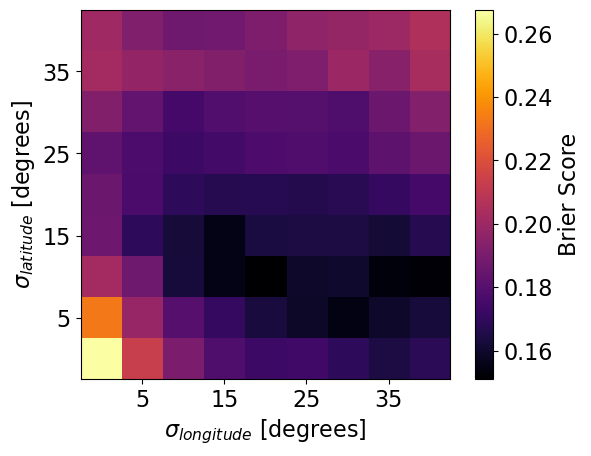

In [74]:
plt.imshow(np.median(lat_lon_briers_arr,axis = 0), origin = 'lower', cmap = 'inferno')
plt.colorbar(label = 'Brier Score')
plt.xlabel(f'$\sigma_{{longitude}}$ [degrees]')
plt.ylabel(f'$\sigma_{{latitude}}$ [degrees]')
plt.xticks(ticks =  np.arange(len(long_dev_list))[1::2], labels = np.array([f'{x:.0f}' for x in long_dev_list])[1::2])
plt.yticks(ticks =  np.arange(len(lat_dev_list))[1::2], labels = np.array([f'{x:.0f}' for x in lat_dev_list])[1::2])
plt.show()

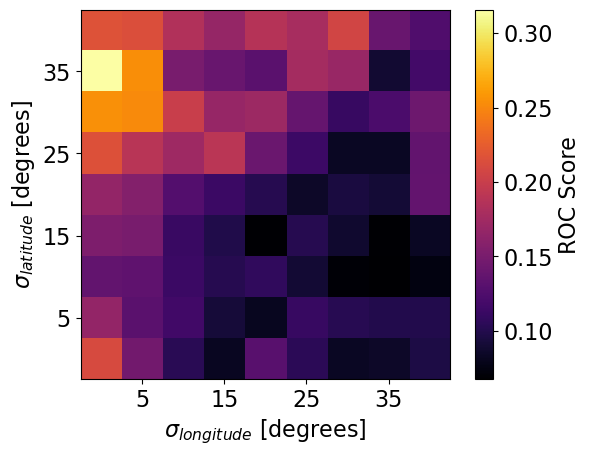

In [75]:
plt.imshow(np.median(lat_lon_ROC_arr,axis = 0), origin = 'lower', cmap = 'inferno')
plt.colorbar(label = 'ROC Score')
plt.xlabel(f'$\sigma_{{longitude}}$ [degrees]')
plt.ylabel(f'$\sigma_{{latitude}}$ [degrees]')
plt.xticks(ticks =  np.arange(len(long_dev_list))[1::2], labels = np.array([f'{x:.0f}' for x in long_dev_list])[1::2])
plt.yticks(ticks =  np.arange(len(lat_dev_list))[1::2], labels = np.array([f'{x:.0f}' for x in lat_dev_list])[1::2])
plt.show()

In [184]:
CR_year_dict = {2009:[2079,2091],
                2010:[2092,2105],
                2011:[2106,2118],
                2012:[2119,2132],
                2013:[2133,2145],
                2014:[2146,2158],
                2015:[2159,2172],
                2016:[2173,2185],
                2017:[2186,2199],
                2018:[2200,2212],
                2019:[2213,2225]}

In [187]:
CR_year_dict[2009]

[2079, 2091]

In [ ]:
rng = np.random.default_rng()

year_list = np.arange(2009,2020)

ensemble_size = 100

lat_dev_list = [0,5,10,15,20,25,30,35,40]
long_dev_list = np.linspace(0,40,len(lat_dev_list))

cr_list = np.arange(cr_min,cr_max)
lat_lon_briers_arr = np.ones((len(cr_list), len(lat_dev_list), len(long_dev_list)))
lat_lon_ROC_arr = np.ones((len(cr_list), len(lat_dev_list), len(long_dev_list)))

total_observed_data = omni_data.dropna(subset = ['V']) # Remove rows with NaN values

for k,year in enumerate(year_list):

    new_cr_list = np.arange(CR_year_dict[year][0],CR_year_dict[year][1]+1)

    for i in range(len(lat_dev_list)):

        #print('lat',lat_dev_list[i])
        file_details_list = [(cr, ensemble_size, lat_dev_list[i]) for cr in new_cr_list]

        ensemble_sets = []
        data_sets = []

        for params in file_details_list:

            # Open forecast output and resample onto OMNI timestep
            ensemble_members, data_chunk = eef.read_and_prepare_ensemble_data(file_details=params, observed_data=omni_data) 
            ensemble_sets.append(ensemble_members)
            data_sets.append(data_chunk)

        ### Combining the ensemble and data chunks into a single timeseries for evaluation
        combined_ensemble_members = []

        # Create a new list of lists
        for ii in range(ensemble_size):
            list_of_cr_members = [[sublist[ii] for sublist in ensemble_sets]]
            combined_ensemble_members.append(np.concatenate(list_of_cr_members[0]))

        combined_data = pd.concat(data_sets)
        ensemble_members = [df.set_index('datetime') for df in ensemble_members]

        for j in range(len(long_dev_list)): 
         #   print(f'lon{long_dev_list[j]}')    
            long_pert_var = long_dev_list[j] # Degrees
            carrington_rotation = 27.2753 * u.day
            
            lp_ensemble_members = [] # Initialise list of lognitudinally perturbed (lp) ensemble members
            #lp_data_chunks = []

            for df in ensemble_members:

                long_pert = rng.normal(loc = 0, scale = long_pert_var, size = 1)
                long_pert_dt = ((long_pert * carrington_rotation.value) / 360) * u.day
                shifted_df, data_chunk = perturb_longitude_onto_data_timestep(long_pert_dt=long_pert_dt, ensemble_member=df, observed_data=total_observed_data)
                lp_ensemble_members.append(scipy.interpolate.CubicSpline(shifted_df.index, shifted_df['vsw']))
                #lp_data_chunks.append(data_chunk)
            
            # Calculate briers score for longitudinally perturbed ensemble set
            ensemble_members_reint = [INT(data_chunk.index) for INT in lp_ensemble_members]

            new_roc_curve = eef.generate_roc_curve_from_ensemble(ensemble_members=ensemble_members_reint, observed_data=data_chunk['V'], probability_threshold=0.7, threshold_range=(200,800), threshold_num=10)
            lat_lon_ROC_arr[k,i,j] = compute_roc_score(roc_curve=new_roc_curve)

            lat_lon_briers_arr[k,i,j] = eef.compute_brier_score_probabilistic(ensemble_members=ensemble_members_reint, observed_data=data_chunk['V'], threshold=BS_thresh, ensemble_size=len(lp_ensemble_members))